### Setup style

In [1]:
import matplotlib.pyplot as plt
import colorsys
from matplotlib import rcParams as rc

rc["legend.markerscale"] = 2.0
rc["legend.framealpha"] = 0
rc["legend.labelspacing"] = 0.1
rc['figure.figsize'] = (20,10)
rc['axes.autolimit_mode'] = 'data'
rc['axes.xmargin'] = 0
rc['axes.ymargin'] = 0.10
rc['axes.titlesize'] = 30
rc['axes.labelsize'] = 24
rc['xtick.labelsize'] = 20
rc['ytick.labelsize'] = 20
rc['axes.grid'] = True
rc['grid.linestyle'] = '-'
rc['grid.alpha'] = 0.2
rc['legend.fontsize'] = 20
rc['legend.loc'] = 'upper left'
rc["figure.autolayout"] = True
rc["savefig.dpi"] = 300

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]
CD = { "Baseline" : colors[0], "Shared" : colors[1], "Task" : colors[2], "GPU_V0" : colors[3], "GPU_V1" : colors[4], "2 GPU_V0" :  colors[5] ,"2 GPU_V1" : colors[6]}

def adjust_brightness(color, amount):
    """Adjust the brightness of a color by a given amount (-1 to 1)."""
    # Convert the color to the RGB color space
    r, g, b = tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
    # Convert the color to the HLS color space
    h, l, s = colorsys.rgb_to_hls(r/255, g/255, b/255)
    # Modify the lightness value
    l = max(0, min(1, l + amount))
    # Convert the color back to RGB and return it
    r, g, b = tuple(round(c * 255) for c in colorsys.hls_to_rgb(h, l, s))
    return f"#{r:02x}{g:02x}{b:02x}"
# Modify the brightness of the colors
colors = [adjust_brightness(color, 0.2) for color in colors]
CD = { "Baseline" : 'r', "Shared" : colors[1], "Task" : colors[2], "GPU_V0" : colors[3], "GPU_V1" : colors[4], "2 GPU_V0" :  colors[5] ,"2 GPU_V1" : colors[0]}

### Create files to store results, if they already exist, empty them.

In [2]:
import numpy as np
import pandas as pd
import os

path = f'/{os.getcwd()}/build/'
fname_base = f'{path}base.csv'
fname_one_gpu_v0 = f'{path}one_gpu_v0.csv'
fname_one_gpu_v1 = f'{path}one_gpu_v1.csv'
fname_two_gpu_v0 = f'{path}two_gpu_v0.csv'
fname_two_gpu_v1 = f'{path}two_gpu_v1.csv'
fname_two_gpu_weak = f'{path}two_gpu_weak.csv'
fname_omp_shared = f'{path}omp_shared.csv'
fname_omp_task = f'{path}omp_task.csv'

def reset_file(filename):
    # Check if the file already exists
    if os.path.isfile(filename):
        # If it does, empty it by opening it in write mode with the 'truncate' option
        with open(filename, 'w', newline='') as f:
            f.truncate()
    else:
        # If it doesn't, create an empty file by opening it in write mode
        with open(filename, 'w', newline='') as f:
            pass

reset_file(fname_base)
reset_file(fname_one_gpu_v0)
reset_file(fname_one_gpu_v1)
reset_file(fname_two_gpu_v0)
reset_file(fname_two_gpu_v1)
reset_file(fname_two_gpu_weak)
reset_file(fname_omp_shared)
reset_file(fname_omp_task)

#Adjust the number of threads to your system!!
NT_shared = 8
NT_task = 32
omp_shared_setting = f"OMP_NUM_THREADS={int(NT_shared)} OMP_PROC_BIND=TRUE" 
omp_task_setting = f"OMP_NUM_THREADS={int(NT_task)} OMP_PROC_BIND=TRUE"

### Run the batch size experiment

In [3]:
fname_omp_shared_bs = f'{path}omp_shared_bs.csv'
fname_omp_task_bs = f'{path}omp_task_bs.csv'
fname_single_gpu_bs = f'{path}single_gpu_bs.csv'
reset_file(fname_omp_shared_bs)
reset_file(fname_omp_task_bs)
reset_file(fname_single_gpu_bs)


for i in range(0,20):
    os.system(f'{omp_shared_setting} {path}benchmarks/omp_multicore 200 {str(2**i)} 10 5 0 {fname_omp_shared_bs}')
    os.system(f'{omp_task_setting} {path}benchmarks/omp_multicore 200 {str(2**i)} 10 5 1 {fname_omp_task_bs}')
    os.system(f'{path}benchmarks/single_gpu 200 {str(2**i)} 100 5 0 {fname_single_gpu_bs}')

### Plot the batch size experiment

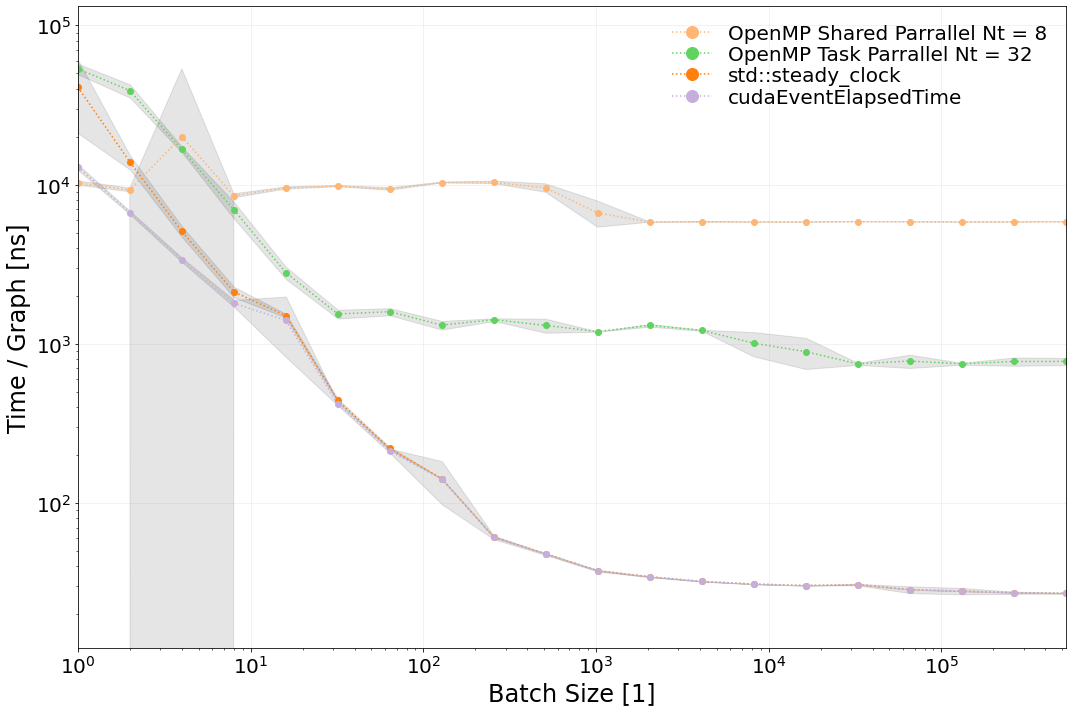

In [4]:
df_omp_shared_bs = pd.read_csv(fname_omp_shared_bs)
df_omp_task_bs = pd.read_csv(fname_omp_task_bs)
df_single_gpu_bs = pd.read_csv(fname_single_gpu_bs)

import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, mark_inset)
fig,ax = plt.subplots(figsize=(15,10))
def add_line(ax, BS, T, SD, label, color, marker, linestyle):
    ax.plot(BS, T, marker=marker, color=color, label=label, linestyle=linestyle)
    ax.fill_between(BS, T - SD, T + SD, alpha=0.1, color='k')
 
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Time / Graph [ns]")
ax.set_xlabel("Batch Size [1]")
add_line(ax, df_omp_shared_bs["BS"].to_numpy(), df_omp_shared_bs["T"].to_numpy(), df_omp_shared_bs["TSD"].to_numpy(), "OpenMP Shared Parrallel Nt = 8", CD["Shared"], 'o', ':')
add_line(ax, df_omp_task_bs["BS"].to_numpy(), df_omp_task_bs["T"].to_numpy(), df_omp_task_bs["TSD"].to_numpy(), "OpenMP Task Parrallel Nt = 32", CD["Task"], 'o', ':')
add_line(ax, df_single_gpu_bs["BS"].to_numpy(), df_single_gpu_bs["T"].to_numpy() + df_single_gpu_bs["TD"].to_numpy(), df_single_gpu_bs["TDSD"].to_numpy(), "std::steady_clock", 'tab:orange', 'o', ':')
add_line(ax, df_single_gpu_bs["BS"].to_numpy(), df_single_gpu_bs["T"].to_numpy(), df_single_gpu_bs["TSD"].to_numpy(), "cudaEventElapsedTime", CD["GPU_V1"], 'o', ':')
ax.legend(loc='best')

### Run the benchmarks

In [5]:
#Change this number if the simulation is taking too long.
#Setting this number to -1 will reduce the batch sizes by 1 order of 2 magnitude
OFFSET_BS = -4


reset_file(fname_base)
reset_file(fname_one_gpu_v0)
reset_file(fname_one_gpu_v1)
reset_file(fname_two_gpu_v0)
reset_file(fname_two_gpu_v1)
reset_file(fname_omp_shared)
reset_file(fname_omp_task)
reset_file(fname_two_gpu_weak)

for i in range(20,201,2):
    os.system(f'{path}benchmarks/baseline {i} {2**(6+OFFSET_BS)} 10 5 0 {fname_base}')
    os.system(f'{omp_shared_setting} {path}benchmarks/omp_multicore {i} {2**(10+OFFSET_BS)} 10 5 0 {fname_omp_shared}')
    os.system(f'{omp_task_setting} {path}benchmarks/omp_multicore {i} {2**(18+OFFSET_BS)} 10 5 1 {fname_omp_task}')
    os.system(f'{path}benchmarks/single_gpu {i} {2**(20+OFFSET_BS)} 100 5 0 {fname_one_gpu_v0}')
    os.system(f'{path}benchmarks/single_gpu {i} {2**(20+OFFSET_BS)} 100 5 1 {fname_one_gpu_v1}')
    os.system(f'{path}benchmarks/multi_gpu {i} {2**(20+OFFSET_BS)} 100 5 0 {fname_two_gpu_v0}')
    os.system(f'{path}benchmarks/multi_gpu {i} {2**(20+OFFSET_BS)} 100 5 1 {fname_two_gpu_v1}')
    os.system(f'{path}benchmarks/multi_gpu {i} {2**(21+OFFSET_BS)} 100 5 1 {fname_two_gpu_weak}')



N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.


### Baseline Benchmark Plot

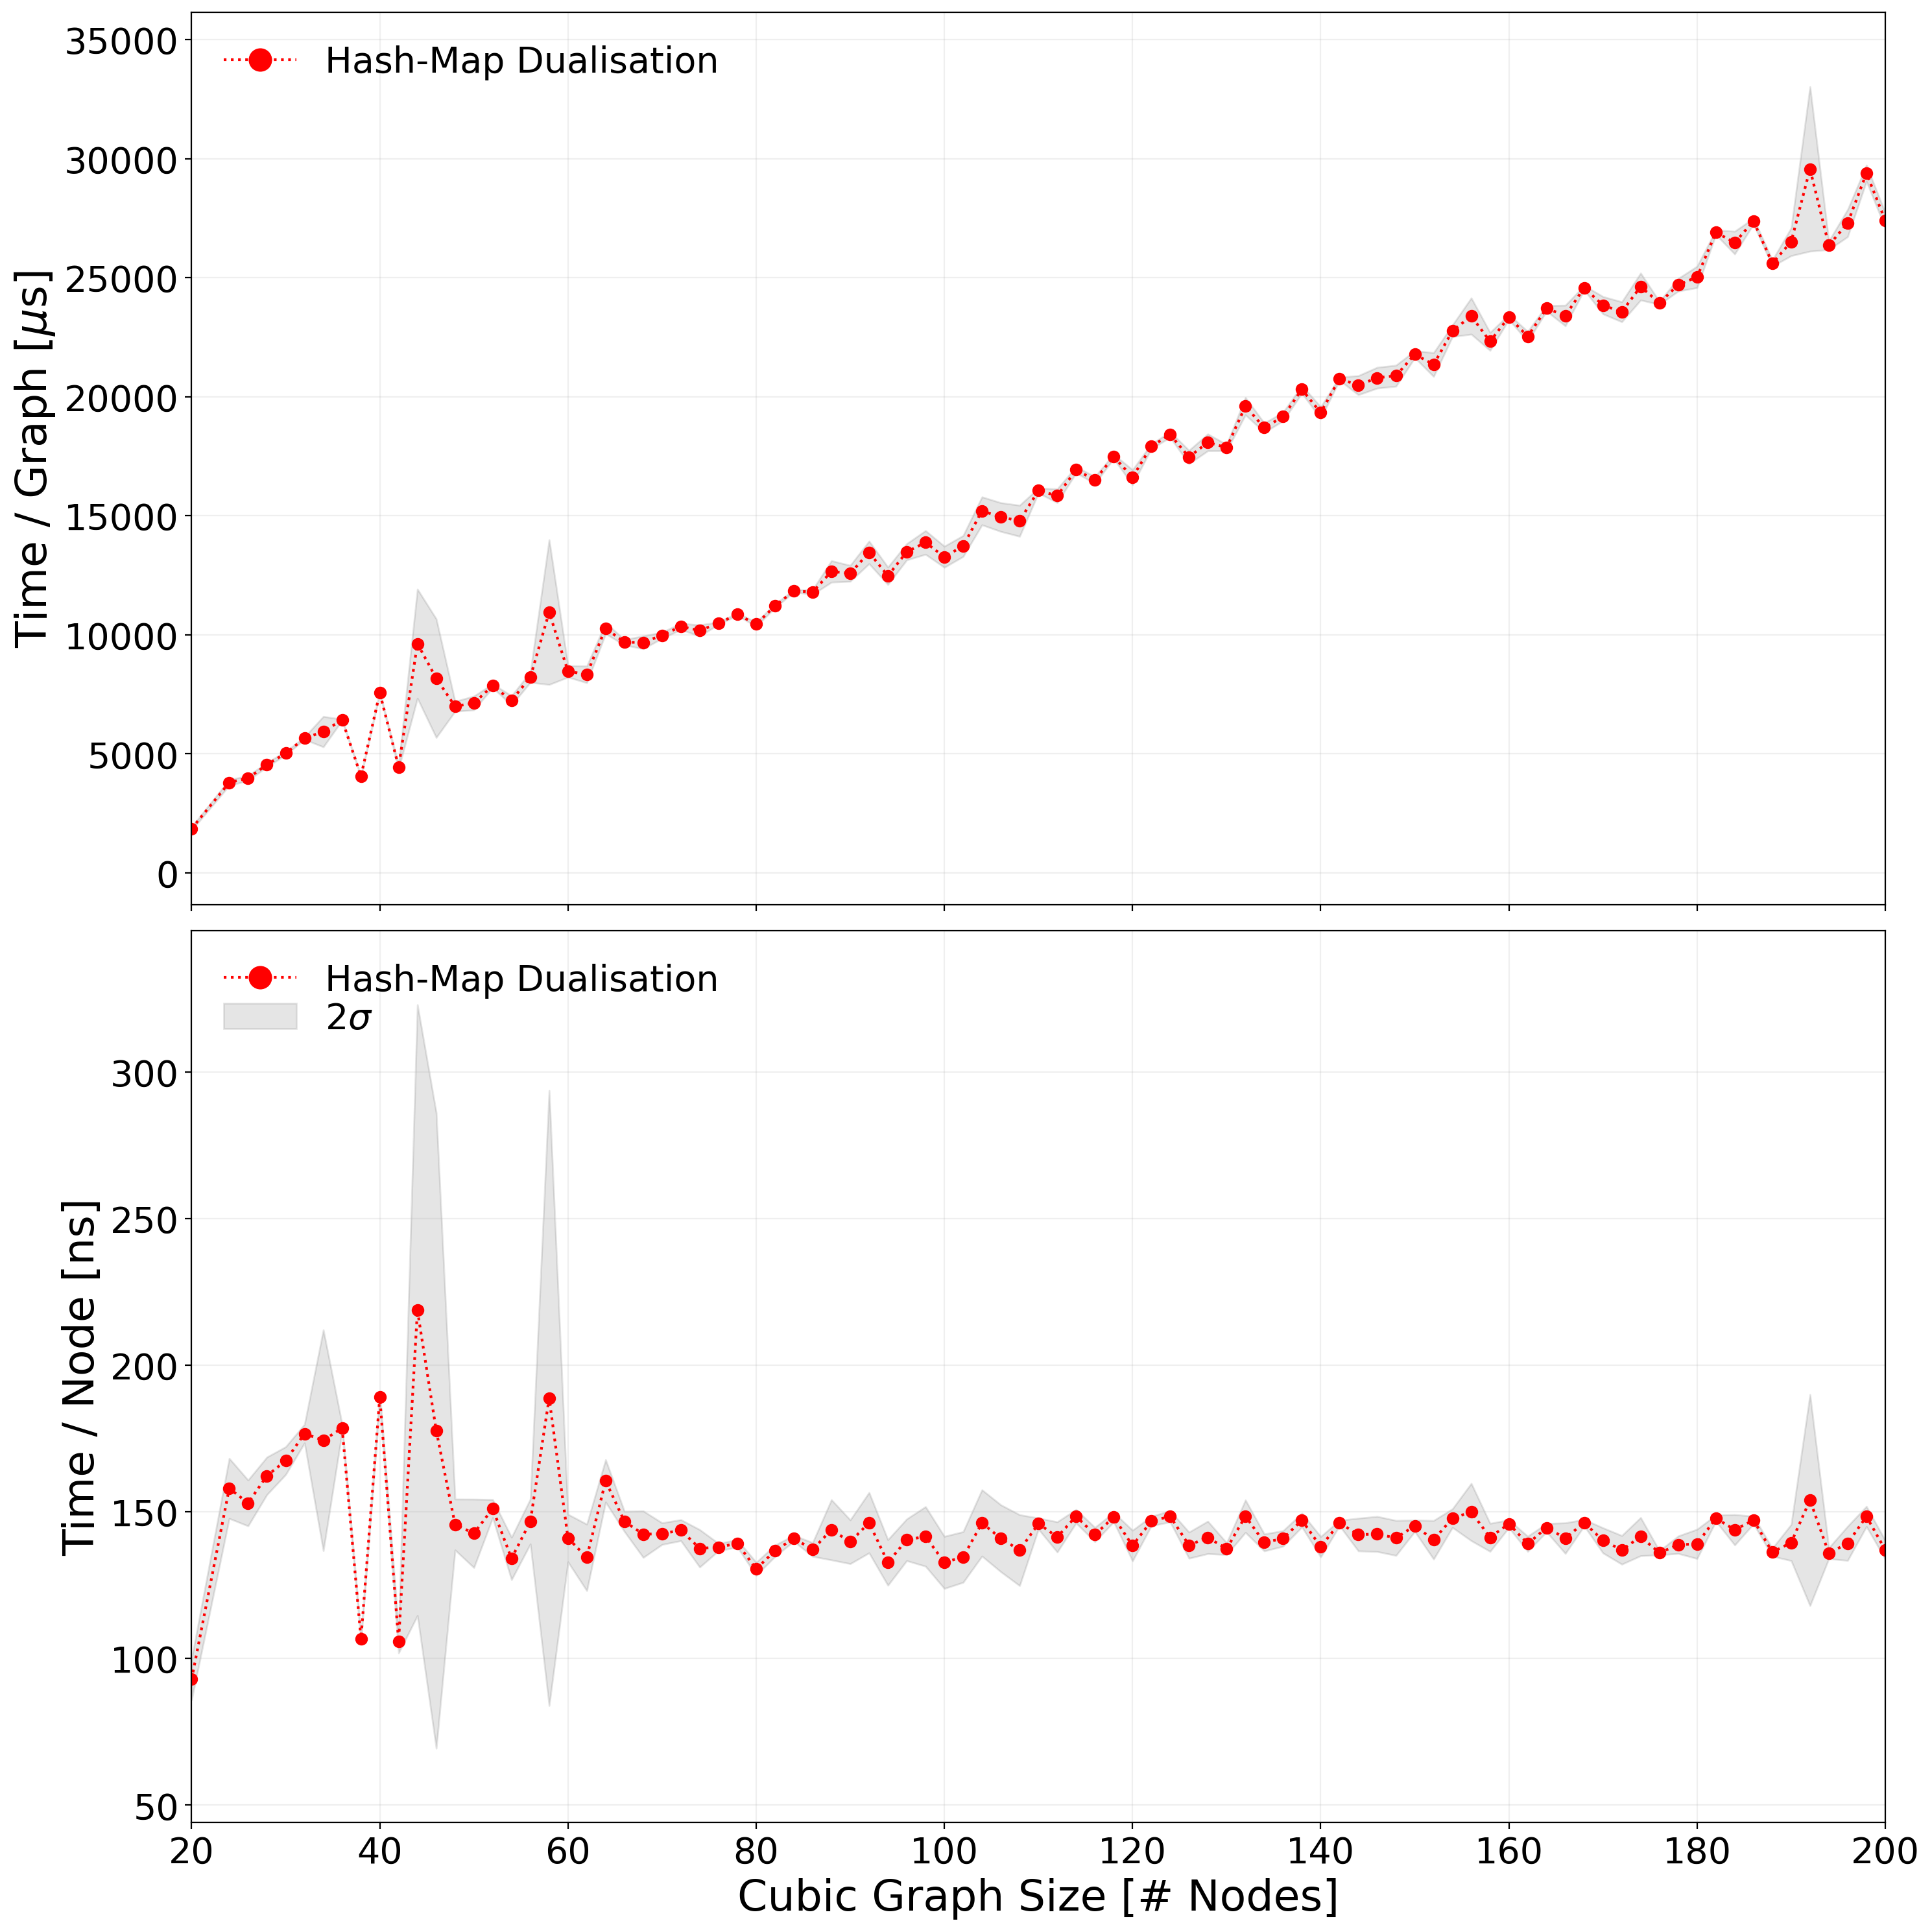

In [6]:
KName0 = r"CUDA Kernel 0"
KName1 = r"CUDA Kernel 1"
TaskName = r"OpenMP Task Parallel [$N_T$ = 32]"
SharedName = r"OpenMP Shared Memory [$N_T$ = 8]"

df_base = pd.read_csv(fname_base)

fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True, dpi=200)
ax[0].plot(df_base["N"].to_numpy(), df_base["T"].to_numpy(), 'o:', color=CD["Baseline"], label="Hash-Map Dualisation")
ax[0].fill_between(df_base["N"].to_numpy(), df_base["T"].to_numpy() - df_base["TSD"].to_numpy(), df_base["T"].to_numpy() + df_base["TSD"].to_numpy(), alpha=0.1, color='k')
ax[0].set_ylabel(r"Time / Graph [$\mu$s]")
ax[0].legend()

ax[1].plot(df_base["N"].to_numpy(), df_base["T"].to_numpy() / df_base["N"].to_numpy(), 'o:', color=CD["Baseline"], label="Hash-Map Dualisation")
ax[1].fill_between(df_base["N"].to_numpy(), (df_base["T"].to_numpy() - df_base["TSD"].to_numpy()*2) / df_base["N"].to_numpy(), (df_base["T"].to_numpy()+df_base["TSD"].to_numpy()*2) / df_base["N"].to_numpy(), color='k', alpha=0.1, label=r"2$\sigma$")
ax[1].set_ylabel(r"Time / Node [ns]")
ax[1].set_xlabel(r"Cubic Graph Size [# Nodes]")
ax[1].legend()



### OMP Shared-memory and Task-parallel Benchmark Plot

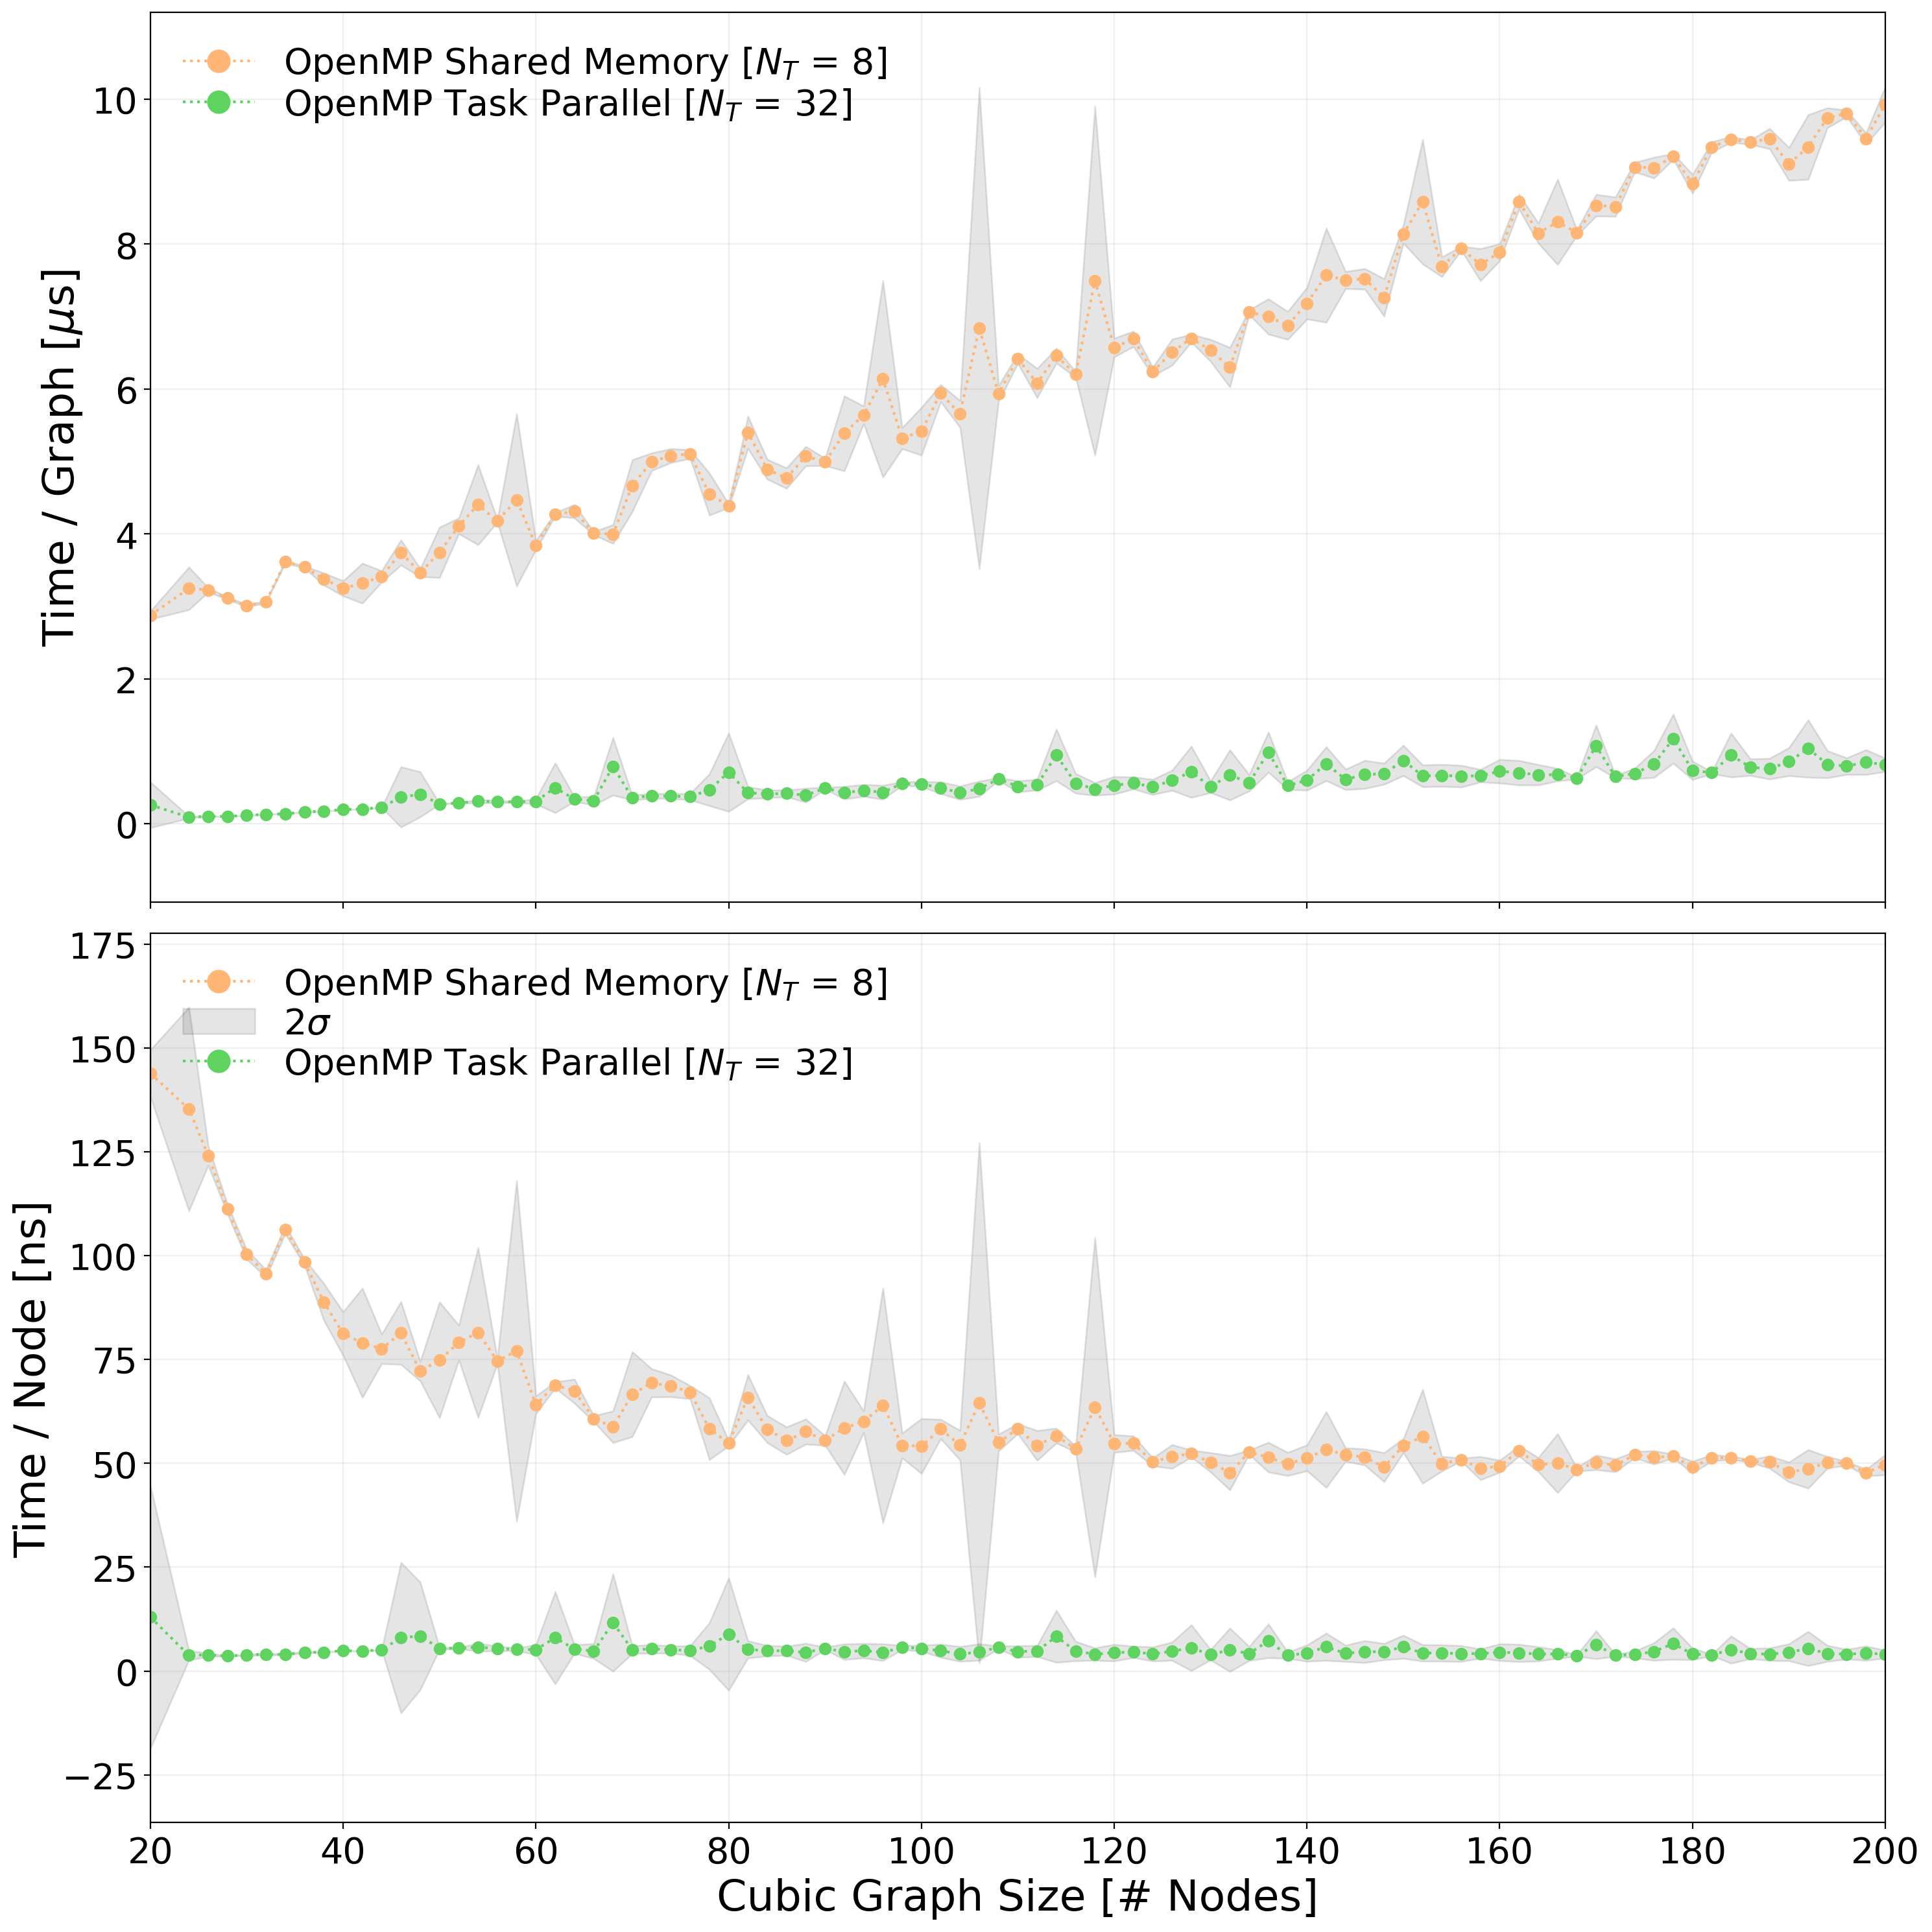

In [7]:
df_omp_shared = pd.read_csv(fname_omp_shared)
df_omp_task = pd.read_csv(fname_omp_task)

fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True, dpi=200)
ax[0].plot(df_omp_shared["N"].to_numpy(), df_omp_shared["T"].to_numpy()/1e3, 'o:', color=CD["Shared"], label=SharedName)
ax[0].fill_between(df_omp_shared["N"].to_numpy(), (df_omp_shared["T"].to_numpy() - df_omp_shared["TSD"].to_numpy())/1e3, (df_omp_shared["T"].to_numpy() + df_omp_shared["TSD"].to_numpy())/1e3, alpha=0.1, color='k')
ax[0].plot(df_omp_task["N"].to_numpy(), df_omp_task["T"].to_numpy()/1e3, 'o:', color=CD["Task"], label=TaskName)
ax[0].fill_between(df_omp_task["N"].to_numpy(), (df_omp_task["T"].to_numpy() - df_omp_task["TSD"].to_numpy())/1e3, (df_omp_task["T"].to_numpy() + df_omp_task["TSD"].to_numpy())/1e3, alpha=0.1, color='k')
ax[0].set_ylabel(r"Time / Graph [$\mu$s]")

ax[1].plot(df_omp_shared["N"].to_numpy(), df_omp_shared["T"].to_numpy() / df_omp_shared["N"].to_numpy(), 'o:', color=CD["Shared"], label=SharedName)
ax[1].fill_between(df_omp_shared["N"].to_numpy(), (df_omp_shared["T"].to_numpy() - df_omp_shared["TSD"].to_numpy()*2) / df_omp_shared["N"].to_numpy(), (df_omp_shared["T"].to_numpy()+df_omp_shared["TSD"].to_numpy()*2) / df_omp_shared["N"].to_numpy(), color='k', alpha=0.1, label=r"2$\sigma$")
ax[1].plot(df_omp_task["N"].to_numpy(), df_omp_task["T"].to_numpy() / df_omp_task["N"].to_numpy(), 'o:', color=CD["Task"], label=TaskName)
ax[1].fill_between(df_omp_task["N"].to_numpy(), (df_omp_task["T"].to_numpy() - df_omp_task["TSD"].to_numpy()*2) / df_omp_task["N"].to_numpy(), (df_omp_task["T"].to_numpy()+df_omp_task["TSD"].to_numpy()*2) / df_omp_task["N"].to_numpy(), color='k', alpha=0.1)
ax[1].set_ylabel(r"Time / Node [ns]")
ax[1].set_xlabel(r"Cubic Graph Size [# Nodes]")
ax[1].legend()
ax[0].legend()

### Dual GPU Benchmark of V0 and V1 Kernels (CUDA)

Text(0, 0.5, 'Time / Node [ps]')

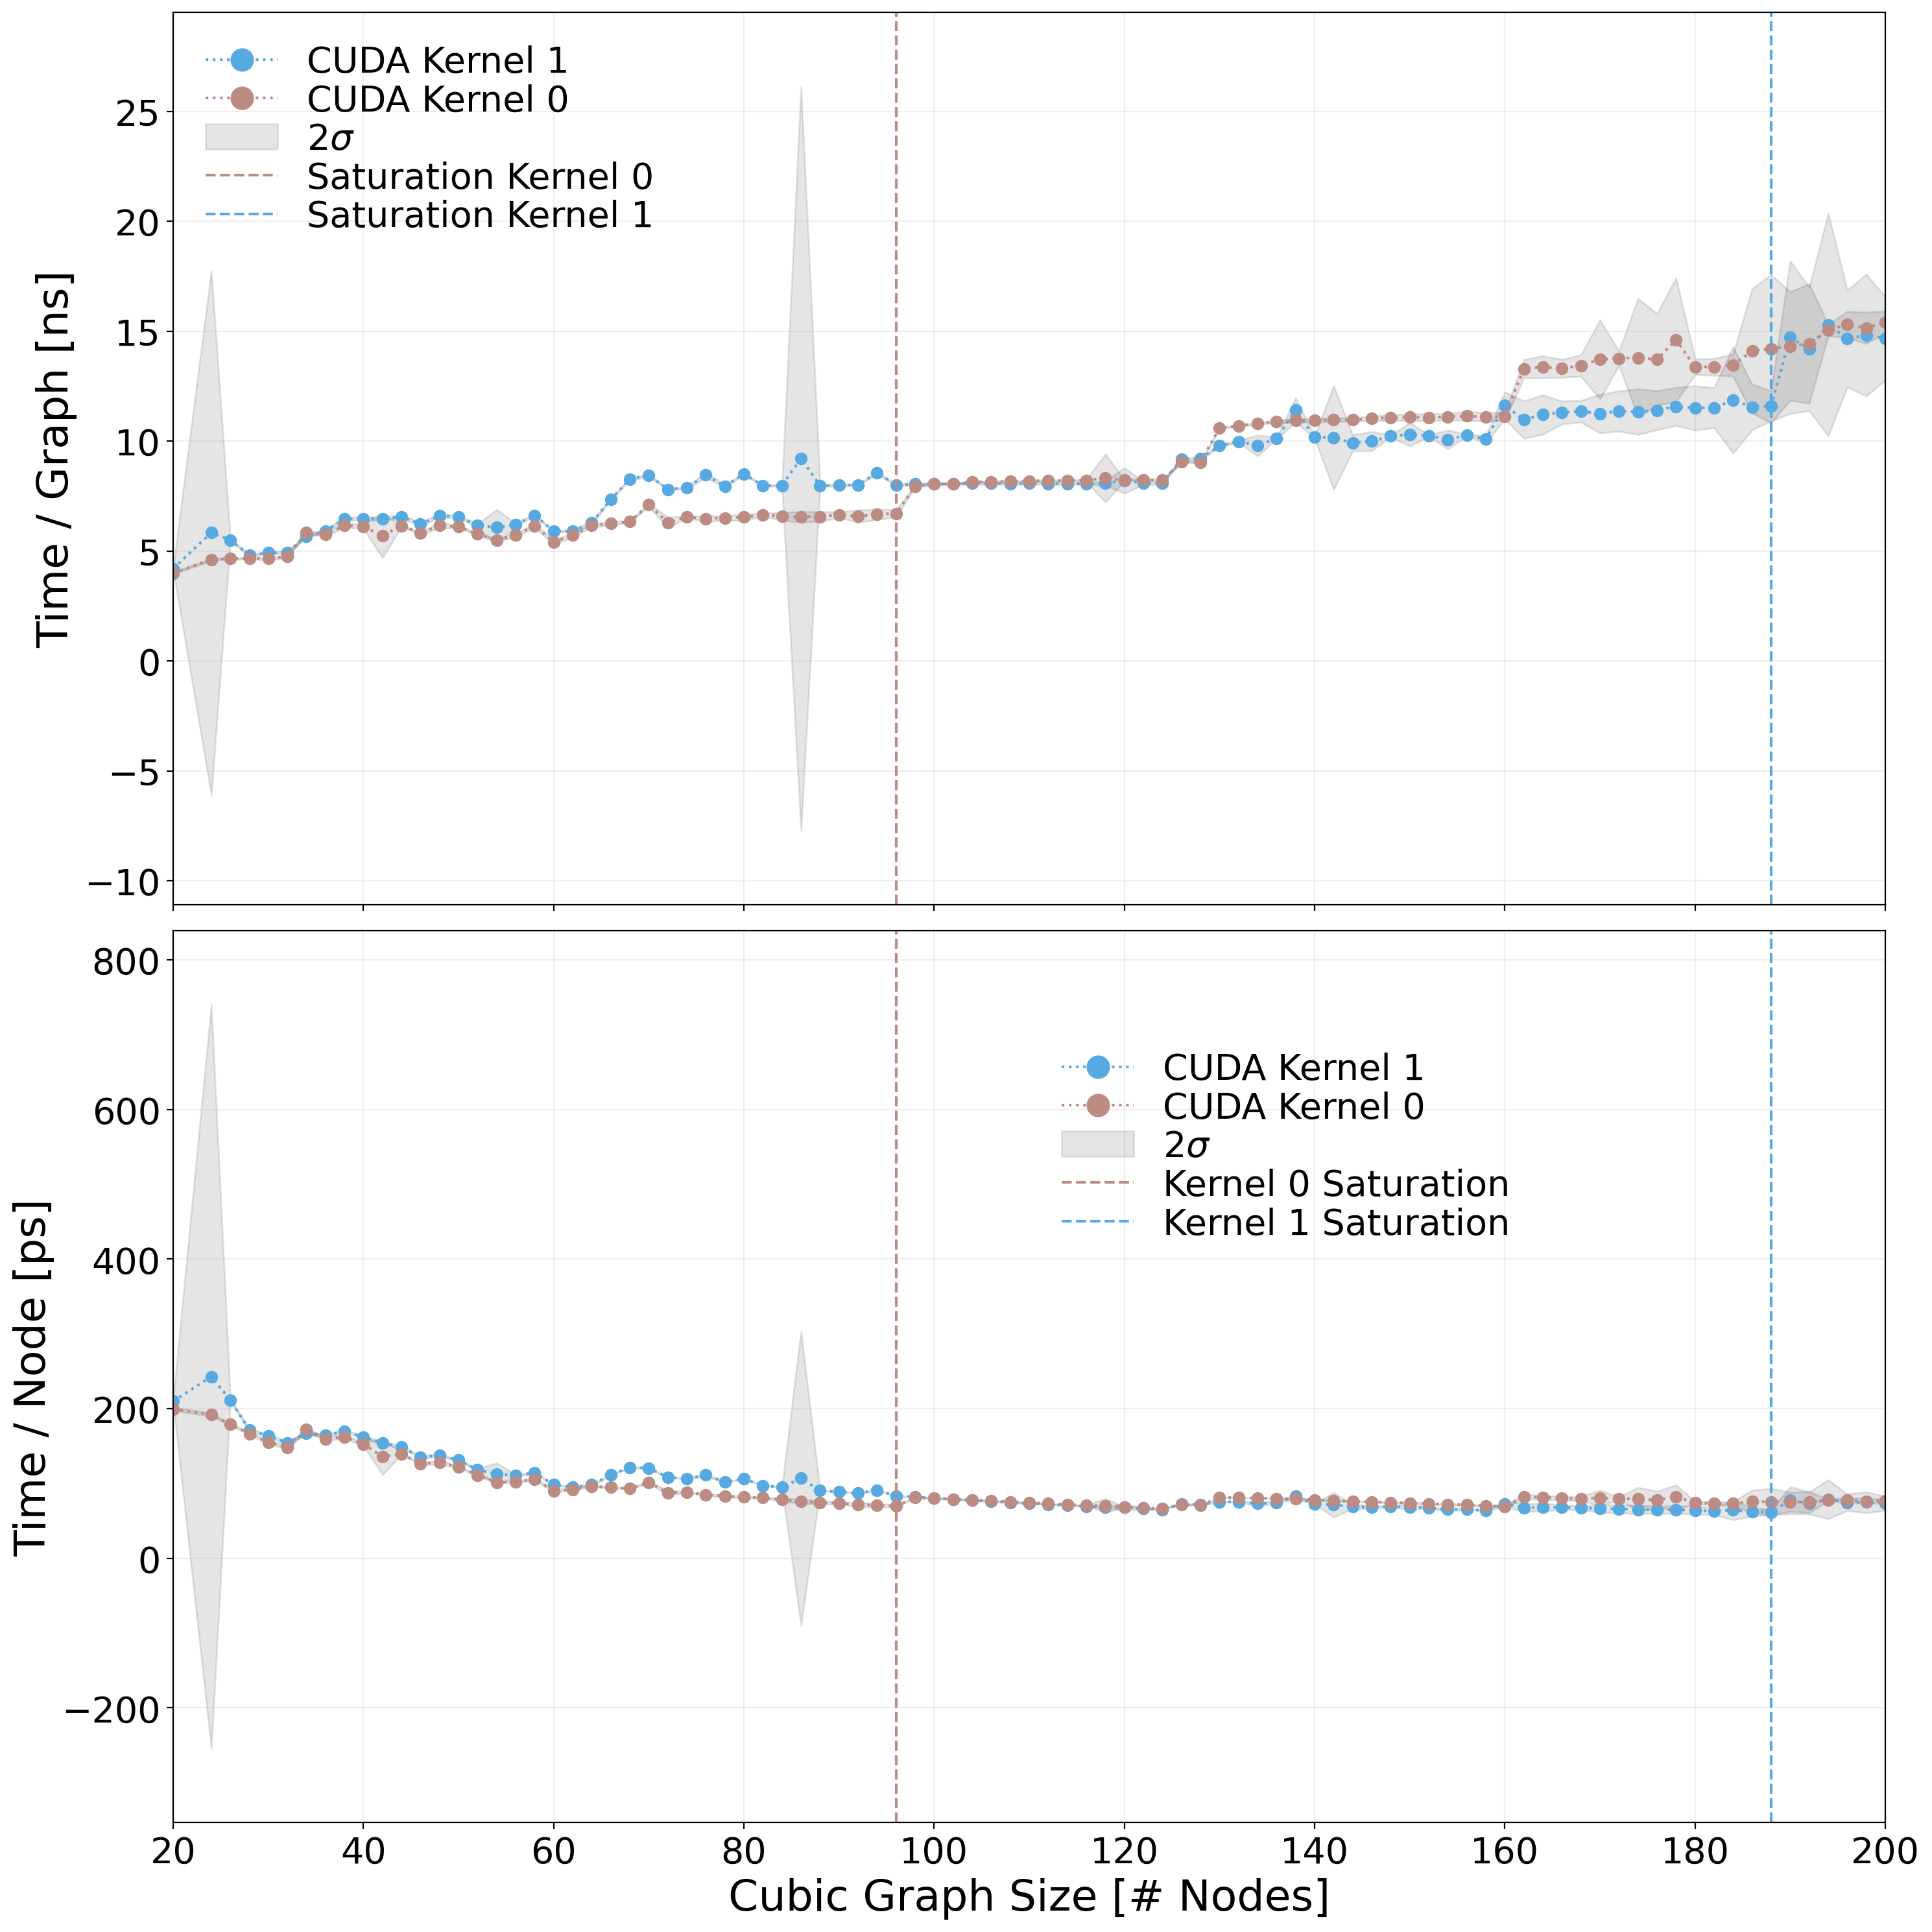

In [8]:
df0 = pd.read_csv(fname_two_gpu_v0)
df1 = pd.read_csv(fname_two_gpu_v1)

fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True, dpi=200)
ax[0].plot(df0["N"].to_numpy(), df1["T"].to_numpy(), 'o:', color=CD["2 GPU_V1"], label=KName1)
ax[0].plot(df0["N"].to_numpy(), df0["T"].to_numpy(), 'o:', color=CD["2 GPU_V0"], label=KName0)
ax[0].fill_between(df0["N"].to_numpy(), (df0["T"].to_numpy() - df0["TSD"].to_numpy()*2), (df0["T"].to_numpy()+df0["TSD"].to_numpy()*2), color='k', alpha=0.1, label=r"2$\sigma$")
ax[0].fill_between(df0["N"].to_numpy(), (df1["T"].to_numpy() - df1["TSD"].to_numpy()*2), (df1["T"].to_numpy()+df1["TSD"].to_numpy()*2), color='k', alpha=0.1)
ylow = ax[0].get_ylim()[0]
yhigh = ax[0].get_ylim()[1]
ax[0].vlines(96, ylow, yhigh, color=CD["2 GPU_V0"], linestyle='--', label=r"Saturation Kernel 0")
ax[0].vlines(188, ylow, yhigh, color=CD["2 GPU_V1"], linestyle='--', label=r"Saturation Kernel 1")
ax[0].set_ylabel(r"Time / Graph [ns]")
ax[0].set_ymargin(0.0)
ax[0].legend(loc="upper left")

ax[1].plot(df0["N"].to_numpy(), df1["T"].to_numpy()*1e3 / df0["N"].to_numpy(), 'o:', color=CD["2 GPU_V1"], label=KName1)
ax[1].plot(df0["N"].to_numpy(), df0["T"].to_numpy()*1e3 / df0["N"].to_numpy(), 'o:', color=CD["2 GPU_V0"], label=KName0)
ax[1].fill_between(df0["N"].to_numpy(), (df0["T"].to_numpy() - df0["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), (df0["T"].to_numpy()+df0["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), color='k', alpha=0.1, label=r"2$\sigma$")
ax[1].fill_between(df0["N"].to_numpy(), (df1["T"].to_numpy() - df1["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), (df1["T"].to_numpy()+df1["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), color='k', alpha=0.1)
ylow = ax[1].get_ylim()[0]
yhigh = ax[1].get_ylim()[1]
ax[1].vlines(96, ylow, yhigh, color=CD["2 GPU_V0"], linestyle='--', label=r"Kernel 0 Saturation")
ax[1].vlines(188, ylow, yhigh, color=CD["2 GPU_V1"], linestyle='--', label=r"Kernel 1 Saturation")
ax[1].legend(bbox_to_anchor=(0.5, 0.9))
ax[1].set_ymargin(0.0)
ax[1].set_xlabel(r"Cubic Graph Size [# Nodes]")
ax[1].set_ylabel(r"Time / Node [ps]")

### Strong and Weak Scaling of the V1 Kernel (CUDA) from 1 to 2 GPUs 

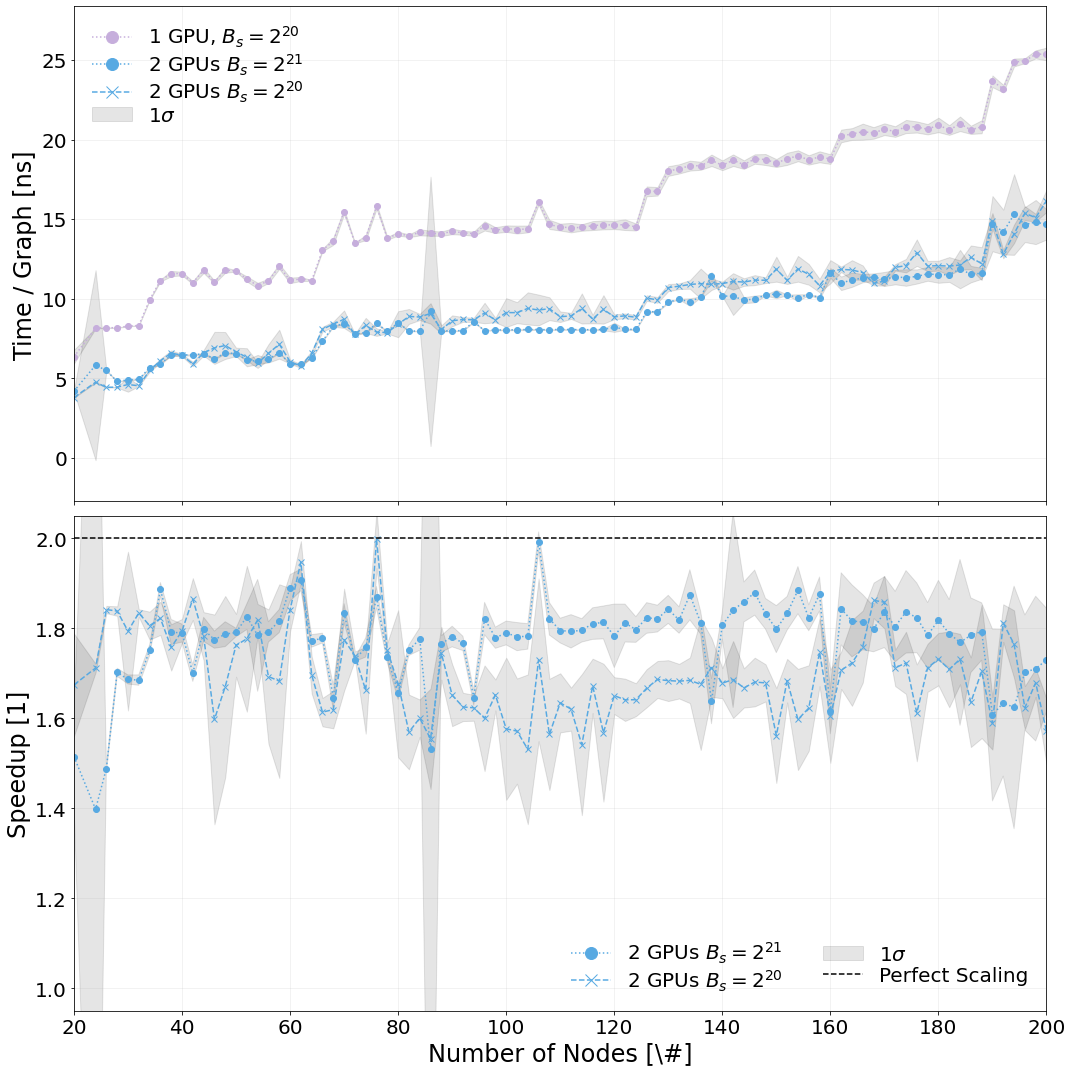

In [9]:
df1 = pd.read_csv(fname_one_gpu_v1)
df3 = pd.read_csv(fname_two_gpu_v1)
df2 = pd.read_csv(fname_two_gpu_weak)
def std_div(a,b, a_std, b_std):
    return a/b * np.sqrt((a_std/a)**2 + (b_std/b)**2)
fig, ax     = plt.subplots(figsize=(15, 15), nrows=2, sharex=True)
ax[0].plot(df1["N"].to_numpy(), df1["T"].to_numpy(), 'o:',  color=CD["GPU_V1"], label=r"1 GPU, $B_s = 2^{20}$")
ax[0].plot(df3["N"].to_numpy(), df3["T"].to_numpy(), 'o:',  color=CD["2 GPU_V1"], label=r"2 GPUs $B_s = 2^{21}$")
ax[0].plot(df2["N"].to_numpy(), df2["T"].to_numpy(), 'x--',  color=CD["2 GPU_V1"], label=r"2 GPUs $B_s = 2^{20}$")
ax[0].fill_between(df1["N"].to_numpy(), df1["T"].to_numpy() - df1["TSD"].to_numpy()*1, df1["T"].to_numpy() + df1["TSD"].to_numpy()*1, alpha=0.1, color='k', label=r"1$\sigma$")
ax[0].fill_between(df3["N"].to_numpy(), df3["T"].to_numpy() - df3["TSD"].to_numpy()*1, df3["T"].to_numpy() + df3["TSD"].to_numpy()*1, alpha=0.1, color='k')
ax[0].fill_between(df2["N"].to_numpy(), df2["T"].to_numpy() - df2["TSD"].to_numpy()*1, df2["T"].to_numpy() + df2["TSD"].to_numpy()*1, alpha=0.1, color='k')
ax[0].set_ylabel("Time / Graph [ns]")
ax[0].legend(loc='upper left')


#Plot speedup
ax[1].plot(df1["N"].to_numpy(), df1["T"].to_numpy()/df3["T"].to_numpy(), 'o:',  color=CD["2 GPU_V1"], label=r"2 GPUs $B_s = 2^{21}$")
ax[1].plot(df1["N"].to_numpy(), df1["T"].to_numpy()/df2["T"].to_numpy(), 'x--',  color=CD["2 GPU_V1"], label=r"2 GPUs $B_s = 2^{20}$")
std_1 = std_div(df1["T"].to_numpy(), df3["T"].to_numpy(), df1["TSD"].to_numpy(), df3["TSD"].to_numpy())
std_2 = std_div(df1["T"].to_numpy(), df2["T"].to_numpy(), df1["TSD"].to_numpy(), df2["TSD"].to_numpy())
ax[1].fill_between(df1["N"].to_numpy(), df1["T"].to_numpy()/df3["T"].to_numpy() - std_1, df1["T"].to_numpy()/df3["T"].to_numpy() + std_1, alpha=0.1, color='k', label=r"1$\sigma$")
ax[1].fill_between(df1["N"].to_numpy(), df1["T"].to_numpy()/df2["T"].to_numpy() - std_2, df1["T"].to_numpy()/df2["T"].to_numpy() + std_2, alpha=0.1, color='k')
ax[1].hlines(2, 20, 200, linestyles='dashed', color='k', label=r"Perfect Scaling")
ax[1].set_ylabel("Speedup [1]")
ax[1].set_xlabel(r"Number of Nodes [\#]")
ax[1].set_ylim(0.95,2.05)
ax[1].legend(loc='lower right', ncol=2)